# Week 4: Eigenvalue & Eigenvectors Application

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse.linalg
import utils

## 1. Webpage navigation model 

Discrete dynamical system is a system where the state changes over time (according to some process). Discrete dynamical system can be represented by a transition matrix $\P$ with entries $p_{ij}$ denoting the transition probability $(i, j)$ from state $j$ to state $i$. Thus probability entries in each column $j$ add up to 1. 

Starting with an initial state $X_0$, the transition to the next state $X_1$ is a linear transformation defined by transition (transformation) matrix $P$: $X_1 = P X_0$. We can keep multiplying by $P$ to move across states: $X_t = P X_{t-1} = P^2 X_{t-2} = ...$

One application of discrete dynamical systems is to model browsing webpages to predict traffic: how user go from 1 page to another by hopping from link to link (assuming users navigate to only linked webpages). We thus have $X_t$ as the probability that the browser is on a particular page at time $t$. Navigation from one page to another advances the model from state vector $X_{t-1}$ to $X_t$. 

Fun fact, this is the m

For example, the browser starts at page 4. And we have the transition matrix $P$. 

In [4]:
X0 = np.array([[0], [0], [0], [1], [0]])
P  = np.array([ 
    [0, 0.75, 0.35, 0.25, 0.85], 
    [0.15, 0, 0.35, 0.25, 0.05], 
    [0.15, 0.15, 0, 0.25, 0.05], 
    [0.15, 0.05, 0.05, 0, 0.05], 
    [0.55, 0.05, 0.25, 0.25, 0]  
]) 

Applying the transformation $X_1 = PX_0$, we have the vector of probabilities that the browser is at one of the 5 pages. 

In [5]:
P @ X0

array([[0.25],
       [0.25],
       [0.25],
       [0.  ],
       [0.25]])

If we apply the transformation $m$ times you can find a vector $X_m$. 

In [10]:
def transformation(m, X0, P):
    X = X0
    for t in range(m):
        X = P @ X
    return X
transformation(20, X0, P)

array([[0.39392366],
       [0.13392366],
       [0.11407667],
       [0.0850993 ],
       [0.27297672]])

As $m$ and the size of the matrix increases, modelling them will become computationally expensive. Eigenvalues and eigenvectors can help reduce hthe amount of calculations. 

In [11]:
eigenvals, eigenvecs = np.linalg.eig(P)
eigenvals, eigenvecs

(array([ 1.        , -0.70367062,  0.00539505, -0.08267227, -0.21905217]),
 array([[-0.76088562, -0.81362074,  0.10935376,  0.14270615, -0.39408574],
        [-0.25879453,  0.050269  , -0.6653158 ,  0.67528802, -0.66465044],
        [-0.2204546 ,  0.07869601, -0.29090665,  0.17007443,  0.35048734],
        [-0.1644783 ,  0.12446953,  0.19740707, -0.43678067,  0.23311487],
        [-0.52766004,  0.56018621,  0.64946163, -0.55128793,  0.47513398]]))

We observe that one eigenvalue of the transition matrix is 1, while others have absolute values less than 1. This is a property of transition matrix, aka Markov matrix. And for Markov matrix, the eigenvector associated with eigenvalue 1 will determine the state of the model in the long run. If $m$ is large enough, $X_m = PX_{m-1} = \lambda X_{m-1} = 1 X_{m-1}$. $X_m$ <b><u>converges</u></b> to the eigenvector of eigenvalue 1 as $m$ increases (under the conditions of irreducibility and aperiodicity).

In [19]:
X = eigenvecs[:, 0] # eigenvector corresponding to 1
X

array([-0.76088562, -0.25879453, -0.2204546 , -0.1644783 , -0.52766004])

The eigenvectors have negative values, but that was because `np.eig` returns eigenvectors with norm 1, by actually eigenvectors can be scaled and still be an eigenvector (on the same line), so we can scale this result to get the probability vector.

In [17]:
X = X / sum(X)
X

array([0.39377747, 0.13393269, 0.11409081, 0.08512166, 0.27307736])

So fter navigating the web for a long time, the probability that the browser is at page 1 is 0.394, of being on page 2 is 0.134, on page 3 0.0114, on page 4 0.085, and finally page 5 has a probability of 0.273

## 2. Principal Component Analysis (PCA)
One of the useful applications of eigenvalues and eigenvectors is dimensionality reduction. PCA can be used to compress data, including image. We'll use a portion of the `Cat and Dog face` dataset from Kaggle to perform PCA. 
To apply PCA on a dataset, we go through 4 main steps:
- Define the covariance matrix
- Compute eigenvalues and eigenvectors of the covariance matrix. Each eigenvectors will be a principal component
- Take $k$ principcal components associated with the $k$ biggest eigenvalues
- Project the original data onto the direction of the principal components

### 2.0 - Load the Data
We begin by loading the images and transforming them to matrix (list of array) form. 

In [27]:
imgs = utils.load_images('./data/') # list of images in pixel (matrix) form
height, width = imgs[0].shape # size of the picture
height, width # size 64 x 64 pixels

(64, 64)

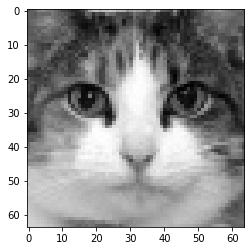

In [28]:
plt.imshow(imgs[1], cmap='gray')

Each image pixel can be considered as a variable. In order to apply PCA we need to flatten each image into a single row vector using `reshape`. If we consider each image (row) as an observation, we'd have 55 observations of 4096 variables $X_1, X_2, ...$

In [34]:
imgs_flatten = np.array([im.reshape(-1) for im in imgs]) # flatten each image in the list to 1 line
imgs_flatten.shape

(55, 4096)

### 2.1 - Get covariance matrix
We need to find the covariance matrix of the `img_flatten` matrix (dataset). The first step is to center the data (substracting the column mean for each variable). The column mean is the average of 55 observations for each variable. 

In [36]:
def center_data(Y):
    mean_vector = np.mean(Y, axis=0) # get a column mean vector (1 X 4069)
    mean_matrix = np.reshape(mean_vector, (1, -1),  ) # repeat the column mean for 55 observations
    X = Y - mean_matrix
    return X

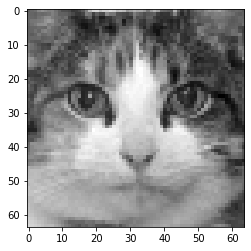

In [41]:
X_centered = center_data(imgs_flatten)
plt.imshow(X_centered[1].reshape(64, 64), cmap='gray')

Now when the data is centered, we find the covariance matrix.

In [42]:
def covar(X):
    return np.cov(X, rowvar=False)

In [45]:
cov_matrix = covar(X_centered)
cov_matrix, cov_matrix.shape

(array([[4230.57037037, 3769.05185185, 3649.88148148, ..., -595.94814815,
         -497.37037037, -428.16296296],
        [3769.05185185, 4051.56363636, 3975.28552189, ..., -398.03905724,
         -384.33670034, -329.35656566],
        [3649.88148148, 3975.28552189, 4065.2983165 , ..., -467.73804714,
         -458.90909091, -414.98754209],
        ...,
        [-595.94814815, -398.03905724, -467.73804714, ..., 4927.1023569 ,
         4632.41750842, 4432.99191919],
        [-497.37037037, -384.33670034, -458.90909091, ..., 4632.41750842,
         4519.31313131, 4381.8013468 ],
        [-428.16296296, -329.35656566, -414.98754209, ..., 4432.99191919,
         4381.8013468 , 4398.68484848]]),
 (4096, 4096))

### 2.2 - Compute eigenvectors & eigenvalues
We need to get eigenvectors associated with $k$ largest eigenvalues (as principal components). We can use `np.linalg.eig` or `scipy.sparse.linalg.eigsh`. 

It's outside the scope of this project, but we can show that as we have only 55 observations, at most 55 eigenvalues of `cov_matrix` will be different from 0. Therefore, to improve computational complexity, we can compute only the biggest 55 eigenvalues $\lambda_1,..., \lambda_{55}$.

In [51]:
np.random.seed(8) # to ensure eigenvectors are the same (because we can have different eigenvectos corresponding to the same eigenvalue)
eigenvals, eigenvecs = scipy.sparse.linalg.eigsh(cov_matrix, k=55)
eigenvals[-10:] # preview the first 10 largest, smallest to largest
eigenvals = eigenvals[::-1] # we reverse the order to have the largest eigenvalues first
eigenvecs = eigenvecs[:, ::-1] 
eigenvals[:10] # same result as np.linalg.eig

array([4198829.23262023, 2484055.10309963, 1536790.5408648 ,
       1011092.7845815 ,  879138.93723794,  839756.42124326,
        479564.23517501,  399091.64921256,  383558.95285037,
        293297.76716381])

Each eigenvector represents one principal component. The eigenvector associated with the largest eigenvalue is the first principal component, the second largest will be the second, and so on. Each principal component extracts some relevant features or patterns from each image. Let's visualize the first 16 components. 

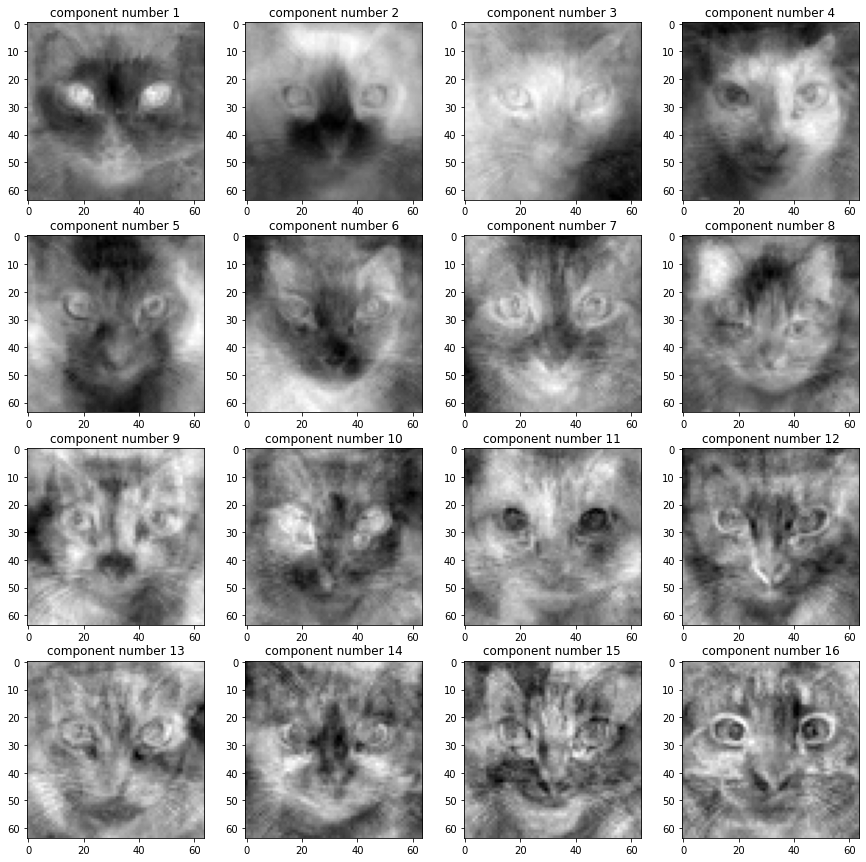

In [53]:
fig, ax = plt.subplots(4, 4, figsize=(15, 15))
for n in range(4):
    for k in range(4):
        ax[n, k].imshow(eigenvecs[:, n*4+k].reshape(height, width), cmap="gray")
        ax[n, k].set_title(f"component number {n*4+k+1}")


### 2.3 - Reduce dimension of the centered data with PCA. 
The dataset originally has 4096 columns. If we want to reduce it to 3 dimensions, we'd need to project the data on 2 eigenvectors associated with 2 largest eigenvalues, so take the product between the data and matrix $V=[v_1, v_2]$.


In [54]:
def perform_PCA(X, eigenvecs, k):
    V = eigenvecs[:,:k] # all rows of the k columns
    return X @ V

In [63]:
Xpca = perform_PCA(X_centered, eigenvecs, 2)
Xpca.shape

(55, 2)

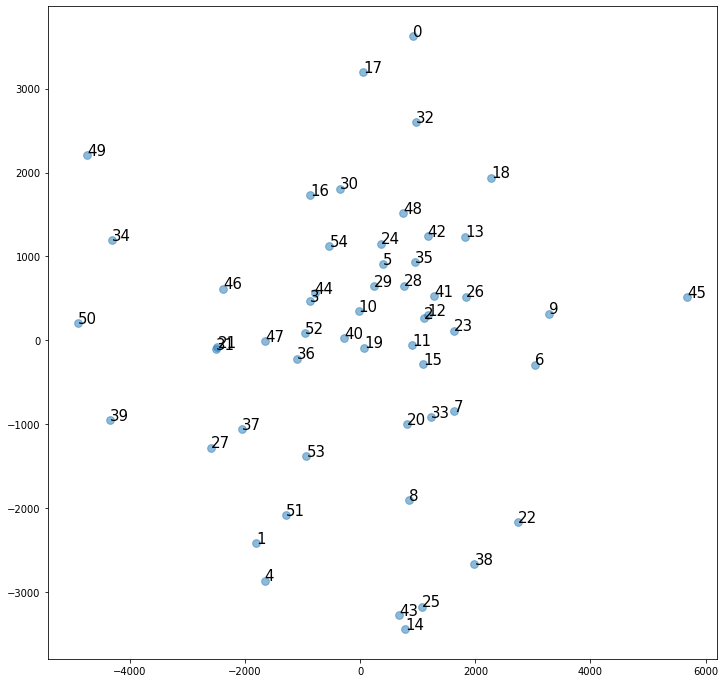

In [65]:
utils.plot_reduced_data(Xpca)

Visualizing the PCA-ed dataset, we can hypothesize that the cats with plots close to each other will look similar. Let's verify that. 

Text(0.5, 0.98, 'Similar cats')

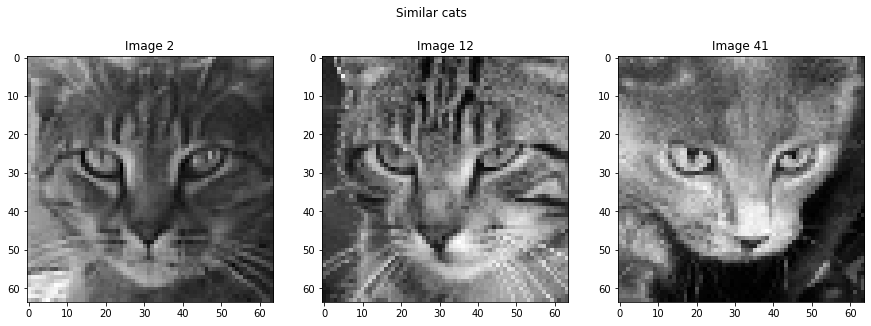

In [69]:
fig, ax = plt.subplots(1,3, figsize=(15,5))
ax[0].imshow(imgs[2], cmap='gray')
ax[0].set_title('Image 2')
ax[1].imshow(imgs[12], cmap='gray')
ax[1].set_title('Image 12')
ax[2].imshow(imgs[41], cmap='gray')
ax[2].set_title('Image 41')
plt.suptitle('Similar cats')

Text(0.5, 0.98, 'Different cats')

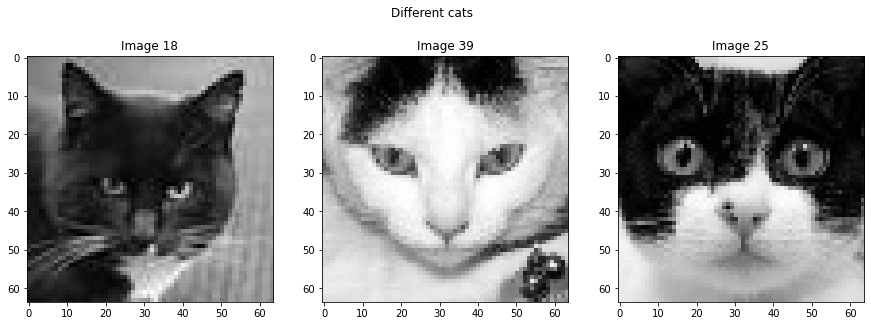

In [68]:
fig, ax = plt.subplots(1,3, figsize=(15,5))
ax[0].imshow(imgs[18], cmap='gray')
ax[0].set_title('Image 18')
ax[1].imshow(imgs[39], cmap='gray')
ax[1].set_title('Image 39')
ax[2].imshow(imgs[25], cmap='gray')
ax[2].set_title('Image 25')
plt.suptitle('Different cats')

### 2.4 - Reconstruct the images from the eigenvectors
We can use dot product to transform the PCA-ed data back to the original: $X_{PCA} = X[v_1, v_2]$ means $X = X_{PCA} V_2^T$.

In [70]:
def reconstruct_image(Xpca, eigenvecs):
    return Xpca @ eigenvecs[:, :Xpca.shape[1]].T

Text(0.5, 1.0, 'reconstruct from 50 component')

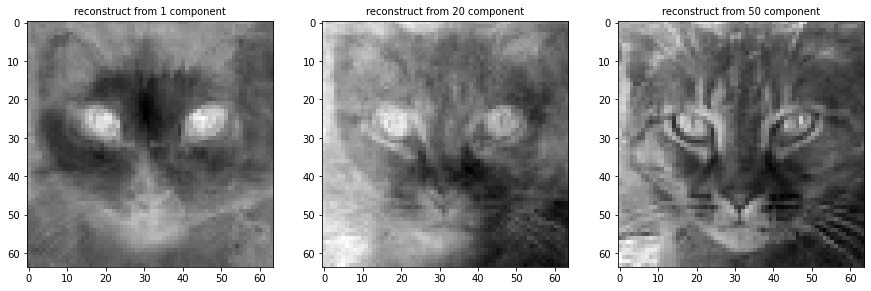

In [77]:
Xpca1 = perform_PCA(X_centered, eigenvecs, 1)
Xpca20 = perform_PCA(X_centered, eigenvecs, 20)
Xpca50 = perform_PCA(X_centered, eigenvecs, 50)
Xrec1 = reconstruct_image(Xpca1, eigenvecs)
Xrec20 = reconstruct_image(Xpca20, eigenvecs)
Xrec50 = reconstruct_image(Xpca50, eigenvecs)

fig, ax = plt.subplots(1,3, figsize=(15,5))
ax[0].imshow(Xrec1[2].reshape(height, width), cmap='gray')
ax[0].set_title('reconstruct from 1 component', size=10)
ax[1].imshow(Xrec20[2].reshape(height, width), cmap='gray')
ax[1].set_title('reconstruct from 20 component', size=10)
ax[2].imshow(Xrec50[2].reshape(height, width), cmap='gray')
ax[2].set_title('reconstruct from 50 component', size=10)


As we have 55 eigenvectors associated with 55 non-zero eigenvalues, 50 components already represent quite fully the original image.

### 2.5 - Explained variance
When deciding how many components to use for PCA, one good criteria is the explained variance. Explained variance is a measure how much variation in a data set can be attributed to each of the principal components, calculated by eigenvalues such that $\lambda_k / sum(\lambda_i)$. In PCA, the first PC (eigenvector associated with the largest eigenvalue) is with the greatest variance (PCA projects data in the directions with biggest variability). Plotting the variance of 55 principal components, we can see that variance is largely explained by the first 20 largest principal components. 

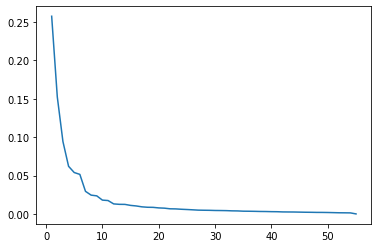

In [78]:
explained_variance = eigenvals / sum(eigenvals)
plt.plot(np.arange(1, 56), explained_variance)